# Nonlinear computations in spiking neural networks through multiplicative synapses - Figure 2
Michele Nardin, James W Phillips, William F Podlaski, Sander W Keemink

We will here reproduce the main figures from the paper.

### Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks

### Plot settings

In [2]:
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['figure.dpi'] = 90

## Common parameters for all simulations

In [3]:
# Simulation parameters
Time = 100 # total time
dt = 0.0001 # time step
Nt=int(Time/dt) # number of time steps

# Network parameters
N = 100 # neurons
K = 3 # dimensionality of input
np.random.seed(12) # for reproducibility
D=np.random.randn(K,N) # decoding matrix
D = D / np.sqrt(np.diag(D.T@D)) # normalize vectors
D = D/10 # reduce size

# thresholds
T = np.diag(D.T@D)/2

### "Real" solution (i.e. best numerical approximation)

In [4]:
from scipy.integrate import odeint

In [5]:
# Lorentz standard parameters
rho=28;sigma=10;beta=8/3
def f(X, t):
  x, y, z = X
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

# initial point (used throughout)
x0 = np.array([-11.40057002, -14.01987468,  27.49928125])
t = np.arange(0.0, Time, dt)
# solution
lorenz = odeint(f, x0, t)

In [6]:
# peak analysis on longer solution
lorenz_long = odeint(f, x0, np.arange(0.0, Time*100, dt))
xl=lorenz_long.T
peaks = find_peaks(xl[2, :], width=210)
zl = xl[2, peaks[0]]

## Representation of "real" solution

inputs: $x, \Delta x$

In [ ]:
x = lorenz.T
Dx = np.gradient(x,axis=1)/dt

Voltage, spikes, rate

In [8]:
V = np.zeros([N,Nt+1])
sr = np.zeros([N,Nt+1])
r = np.zeros([N,Nt+1])
r[:,0] = np.array(np.linalg.pinv(D)@x0) # pseudo-inverse
V[:,0] = 0.9*T

Simulation

In [9]:
for t in range(Nt):
    V[:,t+1] = V[:,t] + dt*(-V[:,t] + D.T@(x[:,t]+Dx[:,t]) - D.T@D@sr[:,t])
    above = np.where(V[:,t+1] > T)[0]
    # introduce a control to let only one neuron fire
    if len(above):
        sr[np.argmax(V[:,t+1]),t+1] = 1/dt
    r[:,t+1] = r[:,t] + dt*(sr[:,t+1] - r[:,t])

In [10]:
# decode network output
x_rep = D@r

Peak analysis

In [11]:
# find consecutive peaks on z-dimension
peaks = find_peaks(x_rep[2, :], width=210)
z_rep = x_rep[2, peaks[0]]

Text(0, 0.5, 'Neuron')

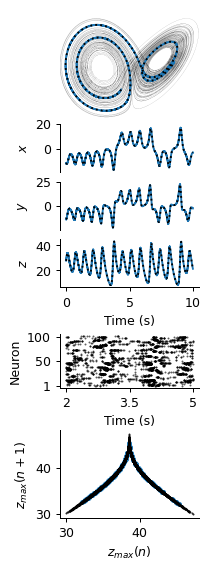

In [12]:
labs=['x','y','z']
#plot limits
yts = [[0,20],[0,25],[20,40]]
lom = 0
lim = 100000

plt.figure(figsize=(2,7.5))

ax = plt.subplot(4,1,1,projection='3d')

# ax.plot(x_reprep[0,lom:lim*10], x_reprep[1,lom:lim*10], x_reprep[2,lom:lim*10],rasterized = True,alpha=0.9,lw=0.1)
ax.plot(x_rep[0,lom:lim*10], x_rep[1,lom:lim*10], x_rep[2,lom:lim*10],alpha=1,lw=0.05,color='k',rasterized = True)
# ax.plot(x_rep[0,0:lim], x_rep[1,0:lim], x_rep[2,0:lim],alpha=1,color='tab:blue')
ax.plot(x_rep[0,lim-75000:lim-50000], x_rep[1,lim-75000:lim-50000], x_rep[2,lim-75000:lim-50000],alpha=1,lw=1.5,color='tab:blue')
ax.plot(x[0,lim-75000:lim-50000], x[1,lim-75000:lim-50000], x[2,lim-75000:lim-50000],alpha=1,color='k',ls='dotted')

plt.axis('off')
plt.xlim([-17.5,15])
plt.ylim([-12,15])
ax.set_zlim([15,38])

for i in range(3):
    ax = plt.subplot(9,1,3+i)
    [ax.spines[s].set_visible(False) for s in ['right','top','bottom']]
    plt.plot(x_rep[i,lom:lim])
    plt.plot(x[i,lom:lim],ls='dotted',c='k',alpha=1)
    plt.ylabel('$'+labs[i]+'$')
    plt.xticks([])
    plt.yticks(yts[i],yts[i])

ax.spines['bottom'].set_visible(True)
plt.xticks([0,50000,100000],[0,5,10])
plt.xlabel('Time (s)')
    
ax = plt.subplot(5,1,5)
plt.scatter(z_rep[:-1], z_rep[1:],marker='.',rasterized=True)
plt.scatter(zl[:-1], zl[1:],marker='.',s=1,color='k',rasterized=True)
[ax.spines[s].set_visible(False) for s in ['right','top']]
plt.xlabel('$z_{max}(n)$')
plt.ylabel('$z_{max}(n+1)$')

ax = plt.subplot(8,1,6)
[ax.spines[s].set_visible(False) for s in ['right','top']]

a=np.where(sr[:,lim-27000:lim-2000])
plt.scatter(a[1],a[0],marker='.',s=1,color='k',alpha=0.7,rasterized=True)
plt.xticks([0,12500,25000],[2,3.5,5])
plt.yticks([0,50,98],[1,50,100])
plt.xlabel('Time (s)')
plt.ylabel('Neuron')

## Computation using multiplicative synapses

Write Lorenz as a Kronecker product
$$ \dot Y = A Y +  B Y\otimes Y $$

In [28]:
# Linear part:
A = np.array([[-sigma,sigma,0],[rho,-1,0],[0,0,-beta]])

# - Nonlinear part:
B = np.array([[0]*9,
              [0,0,-1]+[0]*6,
              [0,1]+[0]*7])

Initialize Voltage, spikes, rate

In [29]:
V = np.zeros([N,Nt+1])
s = np.zeros([N,Nt+1])
r = np.zeros([N,Nt+1])

# Set initial conditions
r[:,0] = np.array(np.linalg.pinv(D)@x0) # pseudo-inverse
V[:,0] = 0.9*T

Network connections

In [30]:
# - fast
O_f = D.T @ D
# - slow
O_s = D.T @ (tau*np.identity(K) + A) @ D
# - nonlinear
O_nl =D.T @ B @ np.kron(D,D)

Simulation

In [31]:
for t in range(Nt):
    V[:,t+1] = V[:,t] + dt*(-tau*V[:,t] - O_f@s[:,t] + O_s @ r[:,t] + O_nl @ np.kron(r[:,t],r[:,t]))
    
    # check if there are neurons whose voltage is above threshold
    above = np.where(V[:,t+1] > T)[0]
    
    # introduce a control to let only one neuron fire
    if len(above):
        s[np.argmax(V[:,t+1]),t+1] = 1/dt
    
    # update rate
    r[:,t+1] = r[:,t] + dt*(s[:,t+1] - tau*r[:,t])

In [32]:
# "Decode" - i.e. multiply rate with decoding matrix D
xn = D@r

Plotting

Text(0, 0.5, 'Neuron')

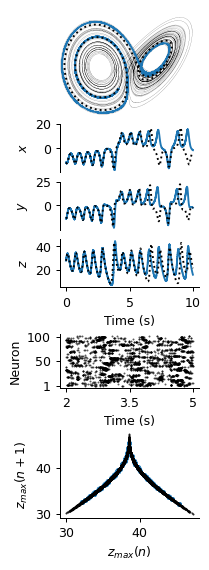

In [33]:
peaks = find_peaks(xn[2, :], width=210) # peaks analysis
zn = xn[2, peaks[0]]

labs=['x','y','z']
plt.figure(figsize=(2,7.5))

ax = plt.subplot(4,1,1,projection='3d')
ax.plot(xn[0,lom:lim*10], xn[1,lom:lim*10], xn[2,lom:lim*10],alpha=1,lw=0.05,color='k',rasterized = True)
ax.plot(xn[0,lim-75000:lim-50000], xn[1,lim-75000:lim-50000], xn[2,lim-75000:lim-50000],alpha=1,lw=1.5,color='tab:blue')
ax.plot(x[0,lim-75000:lim-50000], x[1,lim-75000:lim-50000], x[2,lim-75000:lim-50000],alpha=1,color='k',ls='dotted')
plt.axis('off')
plt.xlim([-17,18])
plt.ylim([-12,15])
ax.set_zlim([15,38])

for i in range(3):
    ax = plt.subplot(9,1,3+i)
    [ax.spines[s].set_visible(False) for s in ['right','top','bottom']]
    plt.plot(xn[i,lom:lim])
    plt.plot(x[i,lom:lim],ls='dotted',c='k',alpha=1)
    plt.ylabel('$'+labs[i]+'$')
    plt.xticks([])
    plt.yticks(yts[i],yts[i])

ax.spines['bottom'].set_visible(True)
plt.xticks([0,50000,100000],[0,5,10])
plt.xlabel('Time (s)')

ax = plt.subplot(5,1,5)
plt.scatter(zn[:-1], zn[1:],marker='.')
plt.scatter(zl[:-1], zl[1:],marker='.',s=1,color='k')
[ax.spines[s].set_visible(False) for s in ['right','top']]
plt.xlabel('$z_{max}(n)$')
plt.ylabel('$z_{max}(n+1)$')

ax = plt.subplot(8,1,6)
[ax.spines[s].set_visible(False) for s in ['right','top']]

a=np.where(s[:,lim-27000:lim-2000])
plt.scatter(a[1],a[0],marker='.',s=1,color='k',alpha=0.7,rasterized=True)
plt.xticks([0,12500,25000],[2,3.5,5])
plt.yticks([0,50,98],[1,50,100])
plt.xlabel('Time (s)')
plt.ylabel('Neuron')

## Basis functions computation

In [13]:
def nonlinND(X, par):
    """ Nonlinear input-output function.
    
    Parameters
    ----------
    x : array
        Input values, 2D
    par : array
        Parameters
        par[0] = offsets, vector
        par[1] = slope (matrix)
        such that y = [par[1]@x+par[0]]+
    Returns
    -------
    Array
        Array of same shape as x
    """
    I = par[1]@X + par[0][:, None]
    y = I
    y[I<0]=0
    return y

In [14]:
def compute_decoderND(A, X, function=lambda x: x, C = 0):
    """Compute the decoder for some output function.
    
    Parameters
    ----------
    A : array
        Input output functions
    xs : array
        Values of x at which to evaluate
    function : function
        A function of the form f(x).
    C : float
        Cost
        
    Returns
    -------
    Array
        Optimal decoder for least squares/linear regression
    """
    # get the desired decoded value for each sample point
    value = function(X)

    # find the optimal linear decoder
    Gamma = A@A.T+C*np.identity(len(A))
    Upsilon = value@A.T
    decoder = np.linalg.solve(Gamma.T, Upsilon.T).T

    return decoder

In [15]:
# basis functions parameters
n = 500 # number of basis functions
ndim=3
scale = 45
np.random.seed(111)
thresholds = (np.random.rand(n)-0.5)*2*scale
slopes = (np.random.rand(ndim, n).T-0.5)*2*10
slopes /= np.linalg.norm(slopes, axis=1)[:, None]
par = [thresholds*2, slopes]

# inputs
nx = 100
x1s = np.linspace(-20, 20, nx)
x2s = np.linspace(-25, 25, nx)
x3s = np.linspace(0, 50, nx)
X = np.array([[x1, x2, x3] for x1 in x1s for x2 in x2s for x3 in x3s]).T

# outputs
y = nonlinND(X, par)

In [16]:
# Lorenz system parameters matrices
A = np.zeros((3, 3))
B = np.zeros((3, 3))
A[0, 0] =-sigma
A[0, 1] = sigma
A[1, 0] = rho
A[1, 1] = -1
A[2, 2] = -beta
B[1, 2] = -1
B[2, 1] = 1

def fun_lorenz(X):
    '''This will calculate a function'''
    out = X[0, :]*np.dot(B, X) #  nonlinear part
    return out

# find decoder
D_lorenz = compute_decoderND(y, X, function=fun_lorenz, C=.1)

In [17]:
times = np.arange(0, Time, dt)
nT = len(times)

In [18]:
# parameters
tau = 0.5

# matrices
F = D.T
Omeg_s = np.dot(F, np.dot(A, D))+np.dot(F, D)/tau
Omeg_f = np.dot(F, D)
xnonlin = np.zeros(3)

# Voltage, spikes, rates
V = np.zeros((N, nT))
o = np.zeros((N, nT))
r = np.zeros((N, nT))

# set rate so to have initial conditions as above
r[:,0] = np.array(np.linalg.pinv(D)@x0) # pseudo-inverse
V[:,0] = 0.9*T

# simulate
for i in range(1, nT):
    # calculate standard voltage daynamics
    dV = -V[:, i-1]/tau # decay
    dV += np.dot(Omeg_s, r[:, i-1]) # slow connections
    dV += -np.dot(Omeg_f, o[:, i-1]/dt) # fast connections

    # calculate nonlinear transformation (shared dendrite pool for xy and xz)
    x_est = D@r[:, i-1]
    dendrites = nonlinND(x_est[:, None], par)
    f_est = (D_lorenz@dendrites)[:, 0]
    dV += F@f_est
    
    # update voltages and firing rates
    V[:, i] = V[:, i-1] + dt*dV 
    r[:, i] = r[:, i-1] + dt*(-r[:, i-1]/tau + o[:, i-1]/dt)

    # find neurons that should spikes, if any
    to_spike = np.where(V[:, i] > T)[0]
    while len(to_spike)>0: 
        # this while-loop can be adjusted to make sure several neurons spike if we are outside the box
        to_pick = np.argmax(V[to_spike,i] - T[to_spike])
        neuron_id = to_spike[to_pick]
        o[neuron_id, i] += 1
        to_spike = []
x_ = np.dot(D, r)

In [19]:
peaks = find_peaks(x_[2, :], width=210) # peak analysis
z_ = x_[2, peaks[0]]

Text(0, 0.5, 'Neuron')

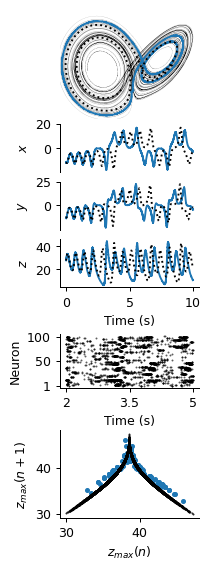

In [20]:
plt.figure(figsize=(2,7.5))

ax = plt.subplot(4,1,1,projection='3d')

ax.plot(x_[0,lom:lim*10], x_[1,lom:lim*10], x_[2,lom:lim*10],alpha=1,lw=0.05,color='k',rasterized = True)
ax.plot(x_[0,lim-75000:lim-50000], x_[1,lim-75000:lim-50000], x_[2,lim-75000:lim-50000],alpha=1,lw=1.5,color='tab:blue')
ax.plot(x[0,lim-75000:lim-50000], x[1,lim-75000:lim-50000], x[2,lim-75000:lim-50000],alpha=1,color='k',ls='dotted')

plt.axis('off')
plt.xlim([-17.5,15])
plt.ylim([-12,15])
ax.set_zlim([15,38])

for i in range(3):
    ax = plt.subplot(9,1,3+i)
    [ax.spines[s].set_visible(False) for s in ['right','top','bottom']]
    plt.plot(x_[i,lom:lim])
    plt.plot(x[i,lom:lim],ls='dotted',c='k',alpha=1)
    plt.ylabel('$'+labs[i]+'$')
    plt.xticks([])
    plt.yticks(yts[i],yts[i])
ax.spines['bottom'].set_visible(True)
plt.xticks([0,50000,100000],[0,5,10])
plt.xlabel('Time (s)')

ax = plt.subplot(5,1,5)
plt.scatter(z_[:-1], z_[1:],marker='.')
plt.scatter(zl[:-1], zl[1:],marker='.',s=1,color='k')
[ax.spines[s].set_visible(False) for s in ['right','top']]
plt.xlabel('$z_{max}(n)$')
plt.ylabel('$z_{max}(n+1)$')

ax = plt.subplot(8,1,6)
[ax.spines[s].set_visible(False) for s in ['right','top']]

a=np.where(o[:,lim-55000:lim-30000])
plt.scatter(a[1],a[0],marker='.',s=1,color='k',alpha=0.7,rasterized=True)
plt.xticks([0,12500,25000],[2,3.5,5])
plt.yticks([0,50,98],[1,50,100])
plt.xlabel('Time (s)')
plt.ylabel('Neuron')